# Unsupervised Bayesian Anomaly Detection Using Beta Binomial Distribution

This notebook goes through an example of how one could use a bayesian framework to do unsupervised anomaly detection. In this particular example, we will consider medical coding behaviors from doctor office visits for evaluation and management services.

Note that all data and results in this notebook are synthetic! To see the data generation process, please see `/data/generate_data.ipynb`.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import sqlalchemy as sa
import sqlparse
from random import randint
import statsmodels.formula.api as sm

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines

sys.path.append('../../../')
import analysis as an
import em_codes as em

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Create DB Engine
db_url = 'postgres://localhost:5432/VincentLa'
db_engine = sa.create_engine(db_url)
conn = db_engine.connect()
conn.execute('CREATE SCHEMA IF NOT EXISTS tutorial_data_ingest;')
metadata = sa.MetaData(bind=conn)

In [3]:
# Define EM code groups
OFFICE_EST_PATIENT = [1, 2, 3, 4, 5]

In [4]:
claim_lines = sa.Table(
    'claim_lines',
    metadata,
    schema='tutorial_data_ingest',
    autoload=True
)

In [5]:
#groupings = pd.read_sql(SPECIALTIES, conn)

In [6]:
claims_subset = pd.read_sql(em.get_claims_base_data(claim_lines, OFFICE_EST_PATIENT), conn)
result_output, distribution_values_output = an.run(conn, claim_lines, OFFICE_EST_PATIENT)

# Exploration

Let's explore the data intuitively!

In [7]:
result_output['All'].head()

,observations,successes,pct_high_encounters,naive_perc,group,a,b,regressed_prob,prob_above_average
servicing_provider_npi,,,,,,,,,
Dr. Jayson Strader,58.0,6.0,0.103448,0.103448,All,6.552539,53.852941,0.108476,0.41173
Dr. Nancy Duncan,94.0,5.0,0.053191,0.053191,All,5.552539,90.852941,0.057596,0.29342
Dr. Kerry Kimbrell,47.0,1.0,0.021277,0.021277,All,1.552539,47.852941,0.031424,0.19763
Dr. Erika Tes,7.0,5.0,0.714286,0.714286,All,5.552539,3.852941,0.590351,0.88580
Dr. Stacy Fontenette,43.0,1.0,0.023256,0.023256,All,1.552539,43.852941,0.034193,0.21170


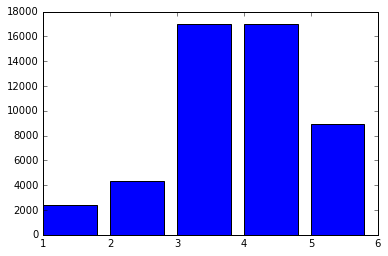

In [8]:
x=plt.bar(claims_subset.groupby('procedure_code').size().index, claims_subset.groupby('procedure_code').size())

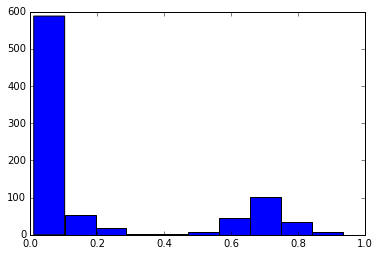

In [9]:
x=plt.hist(result_output['All'].pct_high_encounters)

# Analysis

In [10]:
result_output['All'].sort_values(['prob_above_average'], ascending=False).head(20)

,observations,successes,pct_high_encounters,naive_perc,group,a,b,regressed_prob,prob_above_average
servicing_provider_npi,,,,,,,,,
Dr. Alice Hill,15.0,14.0,0.933333,0.933333,All,14.552539,2.852941,0.836090,0.97953
Dr. Abbie Castaneda,69.0,57.0,0.826087,0.826087,All,57.552539,13.852941,0.805996,0.97723
Dr. Linda Hardin,24.0,21.0,0.875000,0.875000,All,21.552539,4.852941,0.816215,0.97581
Dr. Ronald Petrey,13.0,12.0,0.923077,0.923077,All,12.552539,2.852941,0.814810,0.97486
Dr. Darnell Robinson,85.0,69.0,0.811765,0.811765,All,69.552539,17.852941,0.795746,0.97377
Dr. Patricia Mata,48.0,39.0,0.812500,0.812500,All,39.552539,10.852941,0.784687,0.97090
Dr. Kendall Sherrill,85.0,67.0,0.788235,0.788235,All,67.552539,19.852941,0.772864,0.96983
Dr. Harriette Godinez,55.0,44.0,0.800000,0.800000,All,44.552539,12.852941,0.776103,0.96941
Dr. Evelyn Johnson,38.0,31.0,0.815789,0.815789,All,31.552539,8.852941,0.780898,0.96918


In [11]:
result_output['All'].describe()

,observations,successes,pct_high_encounters,naive_perc,a,b,regressed_prob,prob_above_average
count,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,54.946387,10.388112,0.207500,0.207500,10.940651,46.411216,0.206274,0.448470
std,26.590800,16.674163,0.272323,0.272323,16.674163,27.492347,0.255270,0.273285
min,2.000000,1.000000,0.010204,0.010204,1.552539,2.852941,0.015463,0.135880
25%,33.000000,2.000000,0.040000,0.040000,2.552539,21.852941,0.047910,0.261625
50%,55.000000,3.000000,0.064516,0.064516,3.552539,43.852941,0.073341,0.329385
75%,78.000000,7.000000,0.200000,0.200000,7.552539,69.852941,0.207280,0.540285
max,113.000000,77.000000,0.933333,0.933333,77.552539,111.852941,0.836090,0.979530


# Results

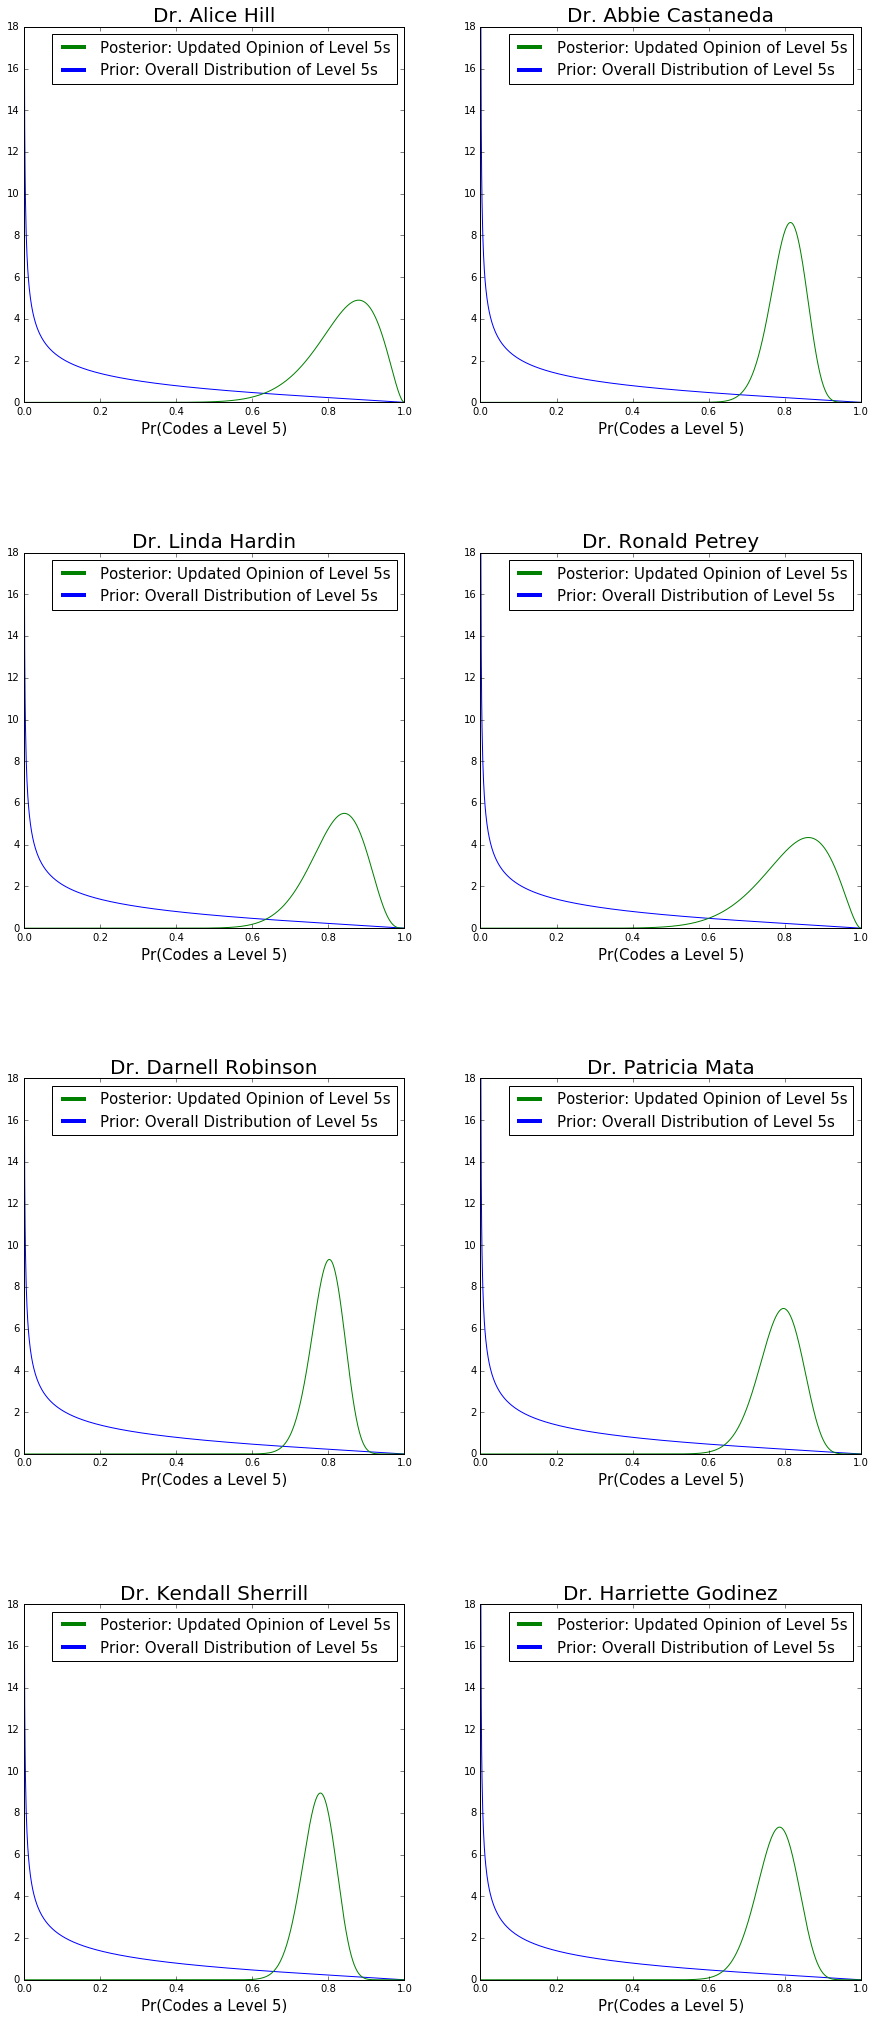

In [12]:
fig = plt.figure(figsize=(15, 35))
gs1 = gridspec.GridSpec(4, 2)
gs1.update(hspace=.4)
ax_list = [fig.add_subplot(ss) for ss in gs1]

distribution_values = distribution_values_output['All']

npis = result_output['All'].sort_values(['prob_above_average'], ascending=False).head(8).index
for i,npi in enumerate(npis):
    ax=ax_list[i]
    ax.plot(distribution_values['prior'][0], distribution_values['prior'][1])
    ax.plot(distribution_values[npi][0], distribution_values[npi][1])
    ax.set_title(npi, fontsize=20)
    ax.set_xlabel('Pr(Codes a Level 5)', fontsize=15)
    posterior = mlines.Line2D([], [], color='green', label='Posterior: Updated Opinion of Level 5s', linewidth=4)
    prior = mlines.Line2D([], [], color='blue', label='Prior: Overall Distribution of Level 5s', linewidth=4)

    ax.legend(handles=[posterior, prior], fontsize=15)

# Validating Results

Do some simple validation
1. Even/Odd personids

In [13]:
columns = [
    claim_lines.c.servicing_provider_npi,
    claim_lines.c.procedure_code,
    claim_lines.c.procedure_name
]
claim_lines_1 = (
    sa.select(columns).
    select_from(claim_lines).
    where(claim_lines.c.personid % 2 == 1)
).correlate(None).alias('claim_lines_1')

claim_lines_2 = (
    sa.select(columns).
    select_from(claim_lines).
    where(claim_lines.c.personid % 2 == 0)
).correlate(None).alias('claim_lines_1')

In [14]:
result_output_1, distribution_values_output_1 = an.run(conn, claim_lines_1, OFFICE_EST_PATIENT)
result_output_2, distribution_values_output_2 = an.run(conn, claim_lines_2, OFFICE_EST_PATIENT)

In [15]:
output1 = result_output_1['All']
output2 = result_output_2['All']

In [16]:
combined = output1.merge(output2, left_index=True, right_index=True)

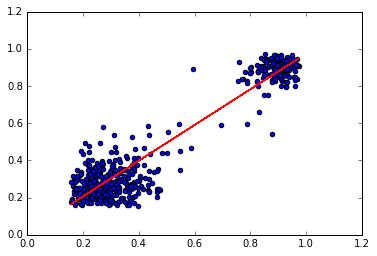

In [17]:
fig, ax = plt.subplots()
fit = np.polyfit(combined.prob_above_average_x, combined.prob_above_average_y, deg=1)
ax.plot(combined.prob_above_average_x, fit[0] * combined.prob_above_average_x + fit[1], color='red')
ax.scatter(combined.prob_above_average_x, combined.prob_above_average_y)

In [18]:
result = sm.ols(formula="prob_above_average_y ~ prob_above_average_x", data=combined).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     prob_above_average_y   R-squared:                       0.912
Model:                              OLS   Adj. R-squared:                  0.912
Method:                   Least Squares   F-statistic:                     5600.
Date:                  Sat, 22 Apr 2017   Prob (F-statistic):          3.09e-286
Time:                          22:40:26   Log-Likelihood:                 546.28
No. Observations:                   539   AIC:                            -1089.
Df Residuals:                       537   BIC:                            -1080.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                0.0145      0.007      1.964      0.050     -4.79e-07     0.029
prob_above_average_x     0.9599      0.013     74.833      0.000         0.935     0.985
==============================================================================
Omnibus:                       10.859   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               17.334
Skew:                          -0.114   Prob(JB):                     0.000172
Kurtosis:                       3.849   Cond. No.                         4.27
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""